### Relative Abundance Plots and Group Significance

Written by Loren Ayala and Jim Griffin  
Date: 5/24/18  
 
 * Contains code for stacked bar plots by metadata groupings and Bonferoni corrected ANOVA statistical tests of group significance.  
 * Phyla were included if they reached > 1% average abundance across the entire dataset and the *Proteobacteria* were split into class level affiliations because they constituted ~35% of the total sequences and were highly diverse.  
  
* Some interesting things to look into are the:
 * *Thaumarcheota* (AOA)
 * *Gemmatimonadetes* (putatively adapted to low soil moisture conditions), although this does not seem to be the case in our results. Not surprising this isn't reproducible at this level. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3165389/]  
   
### TODO:

* Finish anova

In [177]:
import numpy as np
import pandas as pd
import os as os
from scipy.stats import f_oneway

# Graphics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
# Functions:
def subset_abundance_df(df, cutoff):
    """Returns a new dataframe containing only rows whose sum > cutoff """
    taxa_to_add = df[df.mean(axis=1) > cutoff]
    return taxa_to_add

def update_columns(df):
    """Coerces columns to a common format"""
    new_cols = [x.upper().replace('R','') for x in df.columns]
    df.columns = new_cols
    return df

def update_index(df):
    """Coerces index to a common format"""
    new_index = [x.upper().replace('R','') for x in df.index]
    df['new_index'] = new_index
    df.set_index('new_index', inplace=True)
    return df


# concept: We want a reproducible way to group the map_df by a column, then subset the relevant_taxa columns by those groupings and average, then output something we can plot.
def get_average_abundance(taxa_df, map_df, column ):
    """Groups map_df by column and for each group average taxa abundances"""

    group_averaged_taxa = pd.DataFrame(index=taxa_df.index, columns = [])
    groups = map_df.groupby(column)
    for ind, group in groups:
        group_averaged_taxa[ind] = taxa_df[group.index].mean(axis=1)
    return group_averaged_taxa

def group_by_range(taxa_df, map_df, column, bins):
    """Groups a taxa dataframe by BINS of the continuous variable COLUMN in MAP_DF."""
    
    group_averaged_taxa = pd.DataFrame(index=taxa_df.index, columns = [])
    for i in range(len(bins)-1):
        start, stop = bins[i], bins[i+1]
        selection = map_df.loc[lambda df: df[column] <= stop,:]
        selection = selection.loc[lambda df: df[column] > start,:]
        stop = str(round(stop,1))
        group_averaged_taxa[stop] = taxa_df[selection.index].mean(axis=1)
    
    return group_averaged_taxa


def multiple_ANOVA(taxa_df, map_df, column):
    """Runs ANOVA on each taxa in taxa_df based on the categories
    specified by column in map_df"""
    
    stats_df = pd.DataFrame(index=taxa_df.index, columns = ['Fstat', 'p_val'])

    # Group by specified column
    grouped = []
    groups = map_df.groupby(column)
    for ind, group in groups:
        grouped.append( taxa_df[group.index] ) 

    # Run ANOVA on each taxon:
    for i in range(15):
        grouped_taxon_abundance = [x.iloc[i,:].values.tolist() for x in grouped]
        anova = f_oneway(*grouped_taxon_abundance)
        stats_df.loc[taxa_df.index[i], :] = anova[0], anova[1]

    return stats_df

In [3]:
# Load data:
# Paths
phylum_level_data = '../Seq_data/vsearch/gg_tax_summary/biom_table_w_tax_L2.txt'
class_level_data = '../Seq_data/vsearch/gg_tax_summary/biom_table_w_tax_L3.txt'
# Load as dataframes
phylum_df = pd.read_table(phylum_level_data, sep='\t', index_col=0)
class_df = pd.read_table(class_level_data, sep='\t', index_col=0)

In [4]:
# High abundance class and phyla
phyla_subset2 = subset_abundance_df(phylum_df, .01)
class_subset = subset_abundance_df(class_df, .06)

# Merge & simplify names
relevant_taxa = pd.concat([phyla_subset2, class_subset], ignore_index=False)
short_names = [x.rsplit('_',1)[-1] for x in relevant_taxa.index]
short_names = [x.split(';')[0] for x in short_names]
relevant_taxa.index = short_names

# Drop proteobacteria:
relevant_taxa.drop(labels='Proteobacteria', axis=0, inplace=True)
relevant_taxa = update_columns(relevant_taxa)

# Import mapfile
map_df = pd.read_csv('../Metadata/ibp_metadata_4.17.18.txt', sep='\t', index_col='SampleID')
map_df = update_index(map_df)

# Standardize sample names and drop low recovery samples:
relevant_taxa = relevant_taxa[map_df.index]
new_ind = relevant_taxa.mean(axis=1).sort_values(ascending=False).index
relevant_taxa = relevant_taxa.reindex(new_ind)


In [5]:
# categorical variables:
depth_tax_df = get_average_abundance(relevant_taxa, map_df, 'MicroNum')
soilType_tax_df = get_average_abundance(relevant_taxa, map_df, 'USDA_soil_series')

# continuous variable:
bins=np.arange(-.1,1.01,0.1)
inundation_tax_df = group_by_range(relevant_taxa, map_df, column ='inundation_fraction-year_average', bins = bins )


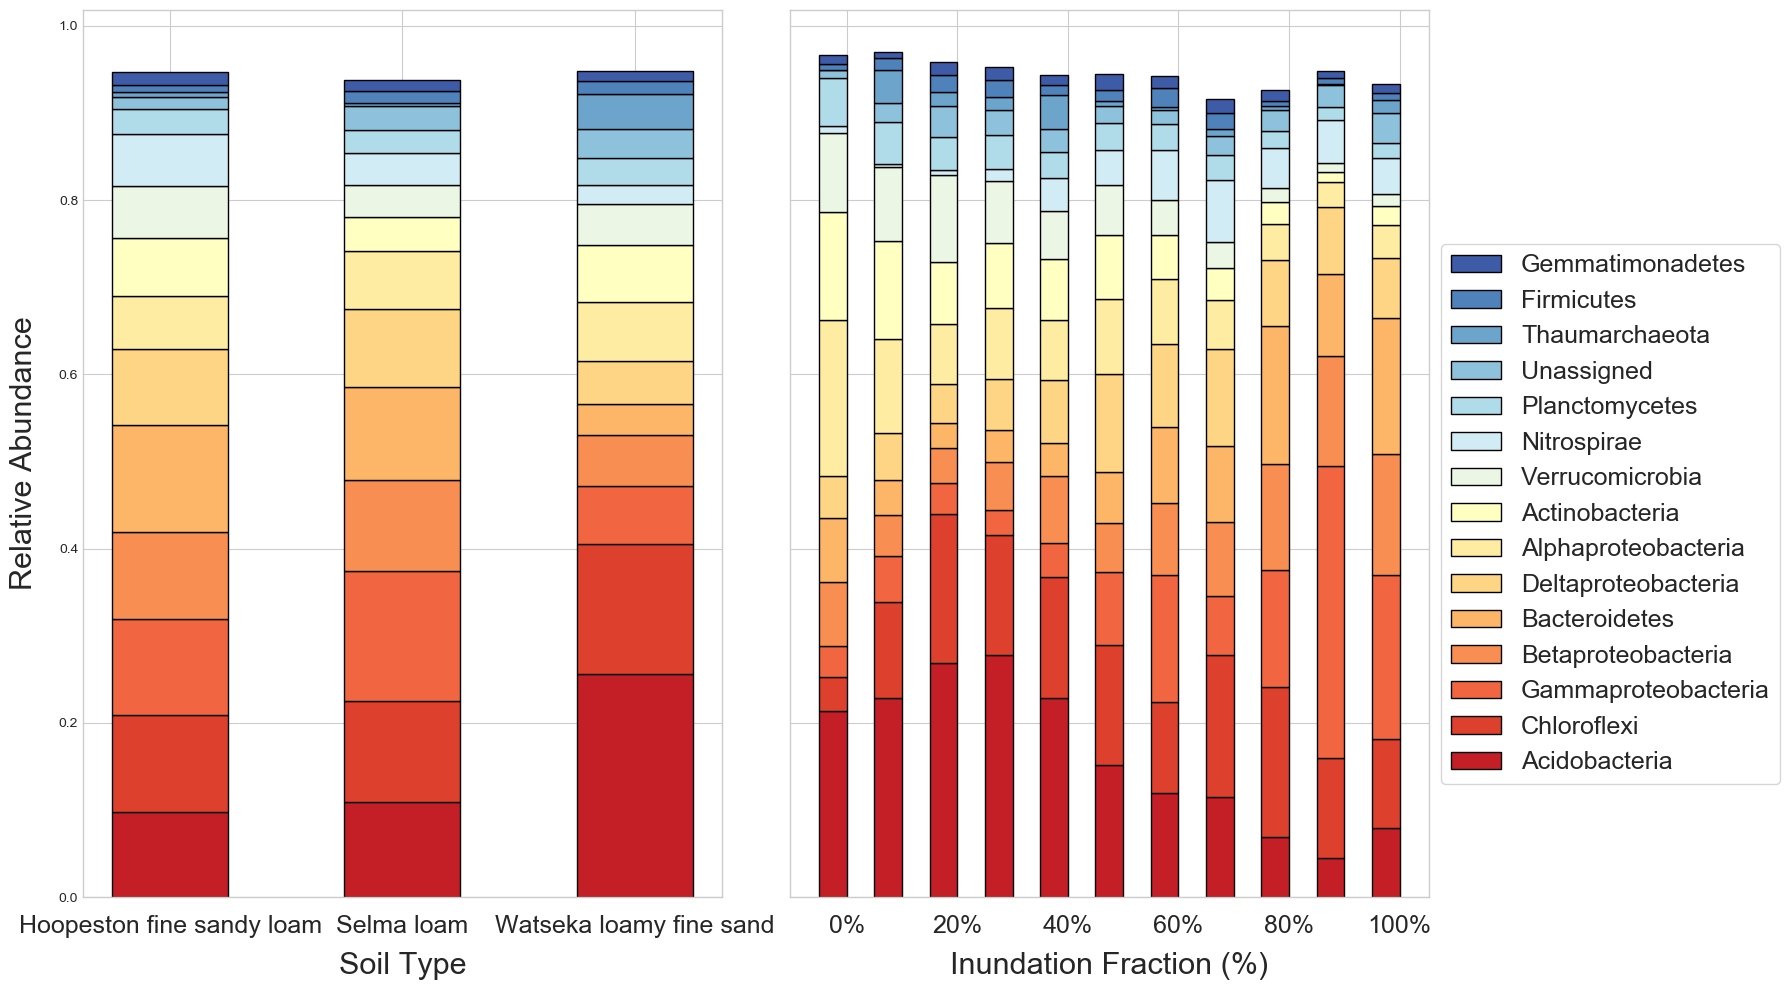

In [6]:
# initialize integer array for each plot and a zeroes array for heights of correct sizes for barplots
depth_ind = np.arange(12)
inun_ind = np.arange(11)
soilType_ind = np.arange(3)

depth_bot = np.zeros_like(depth_ind, dtype=float)
inun_bot = np.zeros_like(inun_ind, dtype=float)
soilType_bot = np.zeros_like(soilType_ind, dtype=float)

# Figure and axis options
sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True)
ax1, ax2, = axes.ravel()
colormap = sns.color_palette('RdYlBu', 15)
matplotlib.rc('ytick', labelsize=20)
fig.set_size_inches(18, 10)

# Labels
ax1.set_ylabel('Relative Abundance',size=22, labelpad=15)
ax1.set_xlabel('Soil Type',size=22, labelpad=10)
ax2.set_xlabel('Inundation Fraction (%)',size=22, labelpad=10)

for i in range (0,15):
    ax1.bar(soilType_ind, soilType_tax_df.iloc[i,:], width=0.5,bottom=soilType_bot, color=colormap[i], edgecolor="black", linewidth=1)   
    ax2.bar(inun_ind, inundation_tax_df.iloc[i,:], width=0.5, bottom=inun_bot, color=colormap[i], edgecolor="black", linewidth=1, label=inundation_tax_df.index[i])
    
    # Start stacked barplot on top of last taxa:
    depth_bot += depth_tax_df.iloc[i,:]
    soilType_bot += soilType_tax_df.iloc[i,:] 
    inun_bot += inundation_tax_df.iloc[i,:]

# Add a legend:
handles, labels = ax2.get_legend_handles_labels()
# Need to add a label argument when calling the plotting function above, and for stacked bar charts need to reverse the order to match the chart. 
ax2.legend(handles[::-1], labels[::-1],frameon=True, bbox_to_anchor=(1.0, .75), fontsize=18)

# Fix this axis label:
ax1.set_xticks(soilType_ind)
ax1.set_xticklabels(('Hoopeston fine sandy loam', 'Selma loam', 'Watseka loamy fine sand'), fontsize=18 )
ax1.xaxis.set_tick_params(pad=13)

ax2.set_xticks(inun_ind[::2]+.25)
ax2.set_xticklabels([str(x)+'%' for x in list(range(0,110,20))], fontsize=18 )
ax2.xaxis.set_tick_params(pad=13)

#plt.show()
fig.tight_layout()
#fig.savefig('../Code/taxonomy_plot.png', dpi=400)

In [15]:
# ANOVA
column = 'USDA_soil_series'
ST_anovas = multiple_ANOVA(relevant_taxa, map_df, column)
sig_ST = ST_anovas[ST_anovas['p_val'] < .05/15]
sig_ST

,Fstat,p_val
Acidobacteria,96.8662,7.29336e-31
Gammaproteobacteria,7.43283,0.000753017
Betaproteobacteria,6.54943,0.00172758
Bacteroidetes,12.8369,5.34957e-06
Deltaproteobacteria,24.2781,2.99704e-10
Actinobacteria,9.99012,7.04681e-05
Nitrospirae,18.8726,2.74226e-08
Unassigned,10.3248,5.18779e-05
Thaumarchaeota,34.5266,9.25471e-14


In [8]:
# ANOVA for the inundation binned taxon abundances:
map_df['inundation_bin'] = map_df['inundation_fraction-year_average'].round(1)
inun_anovas = multiple_ANOVA(relevant_taxa, map_df, column = 'inundation_bin')
sig_inun = inun_anovas[inun_anovas['p_val'] < .05/15]
sig_inun

,Fstat,p_val
Acidobacteria,26.5899,2.45141e-32
Chloroflexi,4.43374,1.13268e-05
Gammaproteobacteria,12.464,6.20506e-17
Betaproteobacteria,4.71453,4.32192e-06
Bacteroidetes,4.89737,2.30787e-06
Deltaproteobacteria,5.9856,5.59822e-08
Alphaproteobacteria,12.6101,4.03632e-17
Actinobacteria,20.3237,4.2226e-26
Verrucomicrobia,13.7568,1.45937e-18
Nitrospirae,7.45895,3.97593e-10


In [11]:
sig_difs = [x for x in sig_inun.index if not x in sig_ST.index]
sig_difs2 = [x for x in sig_ST.index if not x in sig_inun.index]
sig_difs

['Chloroflexi',
 'Alphaproteobacteria',
 'Verrucomicrobia',
 'Planctomycetes',
 'Firmicutes',
 'Gemmatimonadetes']

In [16]:
inundation_tax_df

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
Acidobacteria,0.213568,0.228122,0.268703,0.278276,0.228516,0.152030,0.119731,0.114562,0.069288,0.044918,0.079714
Chloroflexi,0.039114,0.111086,0.170861,0.137784,0.139252,0.137562,0.104509,0.162717,0.171612,0.114359,0.101948
Gammaproteobacteria,0.035103,0.051872,0.036103,0.028611,0.038304,0.083604,0.145518,0.068121,0.134725,0.335195,0.187804
Betaproteobacteria,0.073723,0.047664,0.039390,0.054965,0.077449,0.056060,0.083111,0.085511,0.121006,0.126424,0.139135
Bacteroidetes,0.073313,0.039879,0.029616,0.036864,0.038108,0.058604,0.086200,0.086302,0.158960,0.093926,0.155818
Deltaproteobacteria,0.047950,0.053638,0.044438,0.057801,0.071431,0.112284,0.096185,0.111617,0.075542,0.077702,0.069155
Alphaproteobacteria,0.179922,0.108503,0.069134,0.081341,0.069450,0.086569,0.073996,0.056923,0.040968,0.028190,0.038150
Actinobacteria,0.123572,0.111777,0.070916,0.074653,0.070349,0.073305,0.050944,0.036578,0.025300,0.011538,0.021292
Verrucomicrobia,0.091024,0.085270,0.099588,0.071882,0.054768,0.057360,0.039993,0.029459,0.016647,0.009918,0.014447
Nitrospirae,0.007198,0.003816,0.005779,0.013928,0.037914,0.039825,0.057080,0.071243,0.045387,0.049571,0.041239


### AOA:AOB ratio  
There's some evidence that AOA and AOB have different pH niches in soil. (Leininger 2006), given the strong dependence of Thaumarchaetoa on soiltype (~pH), do we see the same thing?

In [21]:
family_taxa_df = pd.read_csv('../Seq_data/vsearch/gg_tax_summary/biom_table_w_tax_L5.txt', sep='\t', index_col=0, skiprows=1)

In [42]:
AOB_index = [x for x in family_taxa_df.index if 'Nitrosomonadaceae' in x]
AOB_sum = family_taxa_df.loc[AOB_index].sum(axis=0)

AOA_index = [x for x in family_taxa_df.index if 'D_1__Thaumarchaeota' in x]
AOA_sum = family_taxa_df.loc[AOA_index].sum(axis=0)

In [85]:
# Sum and drop no data samples:
AOB_frac = AOB_sum / (AOB_sum + AOA_sum)
AOB_frac.index = [x.upper().replace('R','') for x in AOB_frac.index]
AOB_frac = AOB_frac[map_df.index]
pH_AOB_df = pd.concat([map_df['pH '], AOB_frac], axis=1)
pH_AOB_df.columns = ['pH', 'AOB_fraction']

# Add color categorical variable for soiltype
colormap = sns.color_palette('Set1',3)
colormap = colormap[::-1]

soiltype_as_factor = pd.factorize(map_df['USDA_soil_series'])
pH_AOB_df['SoilColor'] = soiltype_as_factor[0]
pH_AOB_df['SoilColor2'] = [colormap[i] for i in pH_AOB_df['SoilColor']]

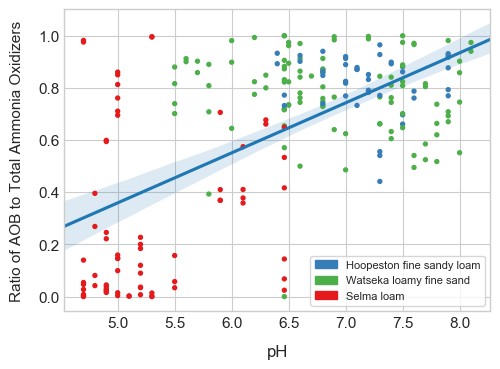

In [186]:
# plot AOB fraction vs pH
#f,ax = plt.subplots(figsize=(5.5,4))

ax=0
ax = sns.regplot(x='pH', y='AOB_fraction', data=pH_AOB_df, scatter_kws={'s':0})
ax.scatter(x=pH_AOB_df['pH'], y = pH_AOB_df['AOB_fraction'], s=8, c=pH_AOB_df['SoilColor2'])


Watseka = mpatches.Patch(color=colormap[0], label='Watseka loamy fine sand')
Hoopestone = mpatches.Patch(color=colormap[1], label='Hoopeston fine sandy loam')
Selma = mpatches.Patch(color=colormap[2], label='Selma loam')

ax.legend(handles=[Hoopestone, Watseka, Selma], frameon=True, fontsize=8)

ax.tick_params(labelsize=11)
ax.set_xlabel('pH', labelpad=10, fontsize=12)
ax.set_ylabel("Ratio of AOB to Total Ammonia Oxidizers", labelpad=10, fontsize=11)
f = plt.gcf()
#print(pH_AOB_df.corr())
f.set_size_inches(5.5,4)
f.savefig('../output/AOB_ratio.png',dpi=400)

In [187]:
pH_AOB_df.corr()

,pH,AOB_fraction,SoilColor
pH,1.000000,0.604415,-0.660708
AOB_fraction,0.604415,1.000000,-0.650667
SoilColor,-0.660708,-0.650667,1.000000
